In [1]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #import Cllback function

import numpy as np
import matplotlib.pyplot as plt

import os

2023-04-12 15:35:38.193286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 15:35:38.922947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rudyrachman16/miniconda3/envs/tf/lib/
2023-04-12 15:35:38.927117: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/rudyrachman16/miniconda3/envs/tf/lib/
2023-04-12 15:35:38.927138: W tensorflow

In [2]:
os.chdir("../dataset")

In [3]:
parent = "2_0_ready"

train_path = f"{parent}/train"
validation_path = f"{parent}/validation"
test_path = f"{parent}/test"

In [4]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen= ImageDataGenerator(
                rescale=1./255,
                # zoom_range=0.15, 
                # width_shift_range=0.2,
                # shear_range=0.15
                )
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#setting train test split
train = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        subset='training' )

test = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

validation = test_datagen.flow_from_directory(
        validation_path,
        target_size=(img_height,img_width),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False )

Found 320 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [7]:
classes = train.num_classes
classes

2

In [8]:
# conv_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
conv_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 

2023-04-12 15:35:40.540983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 15:35:40.570687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 15:35:40.570772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 15:35:40.572036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [9]:
conv_model.trainable = False

In [10]:
def main_model(tl_model,classess):
    m_model=tl_model.output
    m_model=Flatten()(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(1024,activation='relu')(m_model)
    m_model=Dense(512,activation='relu')(m_model)
    m_model=Dense(classess,activation='softmax')(m_model)
    return m_model



In [11]:
combining_model=main_model(conv_model, classes)

In [12]:
model=Model(inputs=conv_model.input, outputs=combining_model)

In [13]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model_checkpoint = ModelCheckpoint(f"../program/model_project.h5", save_weights_only=True, save_best_only=True, monitor="val_accuracy")
learning_rate_reduce = ReduceLROnPlateau(monitor='val_accuracy',min_lr=0.00001)#Change learning rate if not performing good enough
callbacks=[learning_rate_reduce, model_checkpoint]

In [15]:
history=model.fit(train, validation_data=validation, epochs=50, callbacks=callbacks)

Epoch 1/50


2023-04-12 15:35:44.460697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-12 15:35:50.890051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-12 15:35:50.898432: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8f043d9630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-12 15:35:50.898464: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-04-12 15:35:50.902589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-12 15:35:51.008953: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

10/10 [==============================] - 14s 560ms/step - loss: 3.8285 - accuracy: 0.4875 - val_loss: 1.5962 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 3s 297ms/step - loss: 0.9849 - accuracy: 0.4844 - val_loss: 0.8390 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 3s 297ms/step - loss: 0.8012 - accuracy: 0.5063 - val_loss: 0.7146 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 3s 313ms/step - loss: 0.7347 - accuracy: 0.4719 - val_loss: 0.7375 - val_accuracy: 0.4474 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 3s 301ms/step - loss: 0.6847 - accuracy: 0.5406 - val_loss: 0.7147 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 3s 307ms/step - loss: 0.6700 - accuracy: 0.5906 - val_loss: 0.7698 - val_accuracy: 0.3421 - lr: 0.0010
Epoch 7/50
10/10 [==============================] - 4s 368ms/step - loss: 0.6498

In [16]:
os.chdir("../program/")
model.load_weights('model_project.h5')  # load best val_accuracy
os.chdir("../dataset/")

In [17]:
test_score=model.evaluate(test)

2/2 [==============================] - 0s 29ms/step - loss: 1.1499 - accuracy: 0.7895


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

target_names=[]
for key in train.class_indices:
    target_names.append(key)

In [19]:
def plot_cfx(cm, classess, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks=np.arange(len(classess))
    plt.xticks(tick_marks, classess, rotation=45)
    plt.yticks(tick_marks, classess)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print('Confusion Matrix dengan Normalisasi')
    else:
        print('Confusion Matrix dengan Tanpa Normalisasi')
    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
        

2/2 [==============================] - 1s 120ms/step
confusion Matrix
Confusion Matrix dengan Tanpa Normalisasi


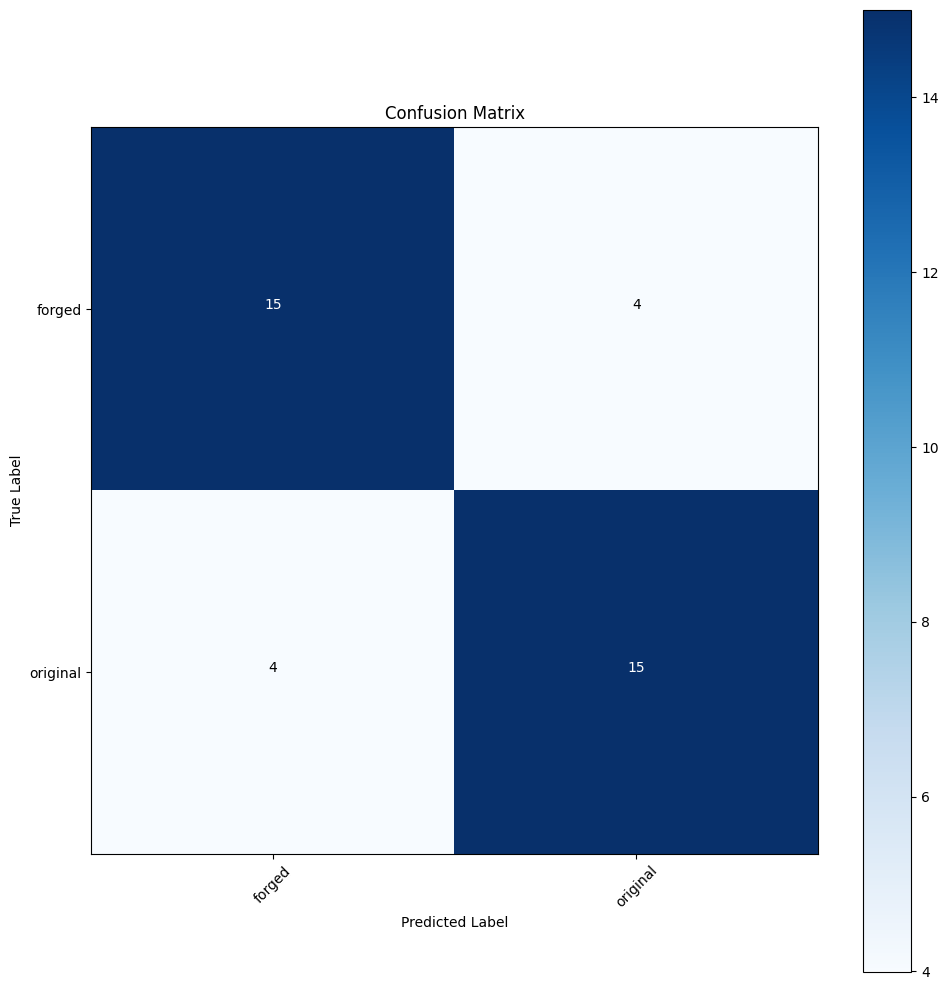

In [20]:
#Confusion Matrix dan Classification Report
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=-1)
print('confusion Matrix')
cm=confusion_matrix(test.classes, y_pred)

plot_cfx(cm, target_names, title='Confusion Matrix')

In [21]:
print('Classification Report')
print(classification_report(test.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      forged       0.79      0.79      0.79        19
    original       0.79      0.79      0.79        19

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.79      0.79      0.79        38



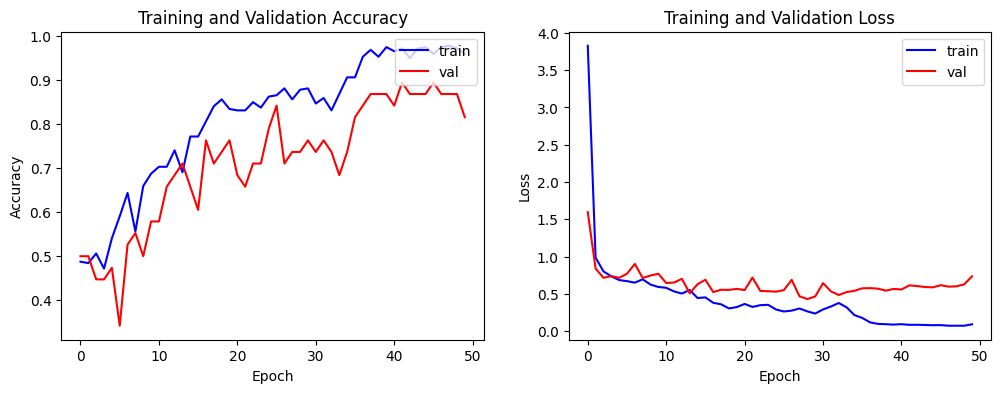

In [22]:
train_accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(train_accuracy))
plt.figure(figsize=(12,4))

#plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracy,'b', label='Training Accuracy')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'], loc='upper right')

#plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs,train_loss,'b', label='Training Loss')
plt.plot(epochs,val_loss,'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'], loc='upper right')

plt.show()